In [1]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1+cu117 --user -f https://download.pytorch.org/whl/cu117/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu117/torch_stable.html


In [2]:
import pandas as pd

In [3]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

df = pd.read_csv('C:/Users/JenMing/Desktop/MBTI/MBTI_test.csv')
df.head()

,type,posts
0,INFJ,What has been the most life-changing experienc...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,"Of course, to which I say I know; that's my bl..."
3,INTJ,"'Dear certain personality, I enjoyed our con..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    #words = [i.lower() + " " for i in words]
    #words = [i for i in words if not "http" in i]
    words = " ".join(words)
    #words = words.translate(words.maketrans('', '', string.punctuation))
    return words

df['posts'] = df['posts'].apply(clean_text)

In [5]:
# 檢查是否有可用的GPU
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

True
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080 Ti


In [6]:
torch.cuda.empty_cache()

In [7]:
df['type'].value_counts()

INFP    1832
INFJ    1469
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [8]:
possible_labels = df.type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'INFJ': 0,
 'ENTP': 1,
 'INTP': 2,
 'INTJ': 3,
 'ENTJ': 4,
 'ENFJ': 5,
 'INFP': 6,
 'ENFP': 7,
 'ISFP': 8,
 'ISTP': 9,
 'ISFJ': 10,
 'ISTJ': 11,
 'ESTP': 12,
 'ESFP': 13,
 'ESTJ': 14,
 'ESFJ': 15}

In [9]:
df['label'] = df.type.replace(label_dict)

In [10]:
from sklearn.model_selection import train_test_split

#在資料集裡面, 我們會選取特徵 (就是"x") , 對應特徵的部分, 會有 Label (標記), (就是"y")
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

#old
#df['data_type'] = ['not_set']*df.shape[0]

#df.loc[X_train, 'data_type'] = 'train'
#df.loc[X_val, 'data_type'] = 'val'

#df.groupby(['type', 'label', 'data_type']).count()

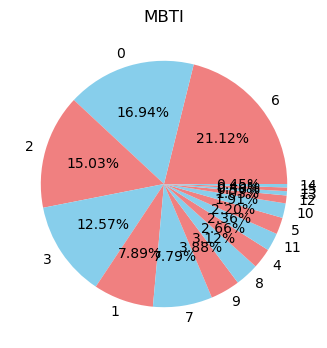

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(8,4) )
y_train_pd = pd.Series(y_train)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [12]:
#上採樣
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
#from imblearn.combine import SMOTEENN
X_train_re = np.array(X_train).reshape(-1, 1)
y_train_re = np.array(y_train).reshape(-1, 1)
X_train_SM, y_train_SM = SMOTE().fit_resample(X_train_re, y_train_re)

#X_train_SM, y_train_SM = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_train_re, y_train_re)
#X_train_SM, y_train_SM = SMOTEENN(random_state=42).fit_resample(X_train_re, y_train_re)

X_val_re = np.array(X_val).reshape(-1, 1)
y_val_re = np.array(y_val).reshape(-1, 1)
X_val_SM, y_val_SM = SMOTE().fit_resample(X_val_re, y_val_re)

#X_val_SM, y_val_SM = BorderlineSMOTE(random_state=42, kind='borderline-2').fit_resample(X_val_re, y_val_re)
#X_val_SM, y_val_SM = SMOTEENN(random_state=42).fit_resample(X_val_re, y_val_re)

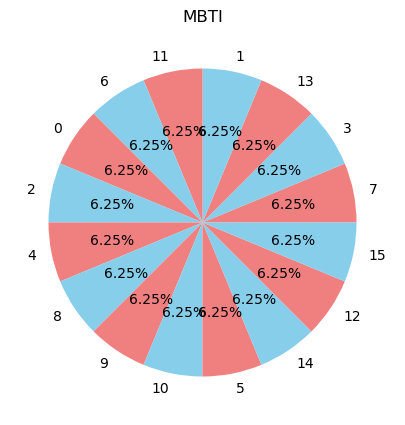

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_SM)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [14]:
#下採樣
from imblearn.under_sampling import TomekLinks
X_train_res, y_train_res = TomekLinks().fit_resample(X_train_SM, y_train_SM)
X_val_res, y_val_res = TomekLinks().fit_resample(X_val_SM, y_val_SM)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train_pd = pd.Series(y_train_res)
y_train_pd.value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'MBTI' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [16]:
df['data_type'] = ['not_set']*df.shape[0]

X_train_flat = X_train_res.flatten()
X_val_flat = X_val_res.flatten()

#X_train_flat = X_train_SM.flatten()
#X_val_flat = X_val_SM.flatten()

df.loc[X_train_flat, 'data_type'] = 'train'
df.loc[X_val_flat, 'data_type'] = 'val'

df.groupby(['type', 'label', 'data_type']).count()

posts
type label data_type       
ENFJ 5     train        116
           val           74
ENFP 7     train        408
           val          267
ENTJ 4     train        142
           val           89
ENTP 1     train        418
           val          267
ESFJ 15    train         22
           val           20
ESFP 13    train         27
           val           21
ESTJ 14    train         24
           val           15
ESTP 12    train         55
           val           34
INFJ 0     train        900
           val          569
INFP 6     train       1077
           val          755
INTJ 3     train        642
           val          449
INTP 2     train        789
           val          515
ISFJ 10    train        102
           val           64
ISFP 8     train        159
           val          112
ISTJ 11    train        128
           val           77
ISTP 9     train        202
           val          135

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].posts.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

C:\Users\JenMing\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
count = 0
for i, n in enumerate(df['posts']):
    if type(n) != str:
        count += 1
        print(f"非字符串值的索引：{i}")
print(f"共有 {count} 個非字符串值")

共有 0 個非字符串值


In [19]:
from transformers import BertConfig

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=len(label_dict),output_attentions=False,
                                                      output_hidden_states=False)
config.hidden_dropout_prob = 0.1
config.attention_probs_dropout_prob = 0.1

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

#config = BertConfig(dropout=0.3)
#model = BertForSequenceClassification.from_pretrained("bert-large-uncased",
#                                                      num_labels=len(label_dict),
#                                                      output_attentions=False,
#                                                      output_hidden_states=False)

#import torch.nn as nn
# 修改 BERT 模型的最後一層
#model.classifier = nn.Sequential(
#    nn.Dropout(0.1),  # 新增 dropout 層
#    nn.Linear(model.config.hidden_size, len(label_dict)),  # 輸出層
#    nn.Softmax(dim=1)  # 新增 softmax 函數
#)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [21]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 50

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

C:\Users\JenMing\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated()/ 1073741824)
print(torch.cuda.max_memory_allocated()/ 1073741824)

print(f"Max memory of GPU 0: {torch.cuda.get_device_properties(0).total_memory / 1024**3} GB")

0.40896177291870117
0.40896177291870117
Max memory of GPU 0: 10.99969482421875 GB


In [24]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, opt_save_dic):
    save_dic = opt_save_dic + 'output_acc.txt'
    f = open(save_dic, "w")
    count_acc  = 0
    count_total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        f.write(f"Class: {label_dict_inverse[label]}\n")
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        f.write(f"Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n")
        count_acc += len(y_preds[y_preds==label])
        count_total += len(y_true)
    print(f'Total: {count_acc}/{count_total}\n')
    f.write(f"Total: {count_acc}/{count_total}\n")
    f.close()

In [25]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [26]:
import random
import numpy as np

torch.cuda.empty_cache()
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
    
best_loss = float('inf') # 設定為無窮大
patience = 5
counter = 0

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    #val_loss => loss_train_avg
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'data_volume/best_model.model')  # 保存最好的模型参数
    else:
        counter += 1
        if counter >= patience:
            print("check")
            break
    print(counter)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.31712347031371
Validation loss: 2.1844066059341607
F1 Score (Weighted): 0.20546909347128842
0


Epoch 2:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.1313118104554394
Validation loss: 2.082882747088514
F1 Score (Weighted): 0.22502544352803394
0


Epoch 3:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.9835773635129987
Validation loss: 2.0948209448719686
F1 Score (Weighted): 0.23160052734134332
1


Epoch 4:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.8181930379999196
Validation loss: 2.124159796683948
F1 Score (Weighted): 0.25586142404976375
2


Epoch 5:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.5829390972121362
Validation loss: 2.2781404346296474
F1 Score (Weighted): 0.25741419091816387
3


Epoch 6:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.3142560826488798
Validation loss: 2.3961825334998257
F1 Score (Weighted): 0.28272500129506895
4


Epoch 7:   0%|          | 0/652 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.0608554469204388
Validation loss: 2.5239255537061713
F1 Score (Weighted): 0.26958757248208837
check


In [27]:
from transformers import BertConfig
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)


opt_save_dic = "data_volume/"
model.load_state_dict(torch.load(opt_save_dic+'best_model.model', map_location=torch.device('cuda')),strict=False)
_, predictions, true_vals = evaluate(dataloader_validation)

accuracy_per_class(predictions, true_vals, opt_save_dic)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: INFJ
Accuracy: 105/569

Class: ENTP
Accuracy: 12/267

Class: INTP
Accuracy: 175/515

Class: INTJ
Accuracy: 160/449

Class: ENTJ
Accuracy: 0/89

Class: ENFJ
Accuracy: 0/74

Class: INFP
Accuracy: 560/755

Class: ENFP
Accuracy: 0/267

Class: ISFP
Accuracy: 0/112

Class: ISTP
Accuracy: 0/135

Class: ISFJ
Accuracy: 0/64

Class: ISTJ
Accuracy: 0/77

Class: ESTP
Accuracy: 0/34

Class: ESFP
Accuracy: 0/21

Class: ESTJ
Accuracy: 0/15

Class: ESFJ
Accuracy: 0/20

Total: 1012/3463



In [28]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.max_memory_allocated())

2275740672
7135204864


In [29]:
!pip list

Package                       Version
----------------------------- ---------------
alabaster                     0.7.12
anaconda-client               1.11.1
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
black                         22.6.0
bleac